<center>
<img src="../../img/ods_stickers.jpg">
## Open Machine Learning Course
<center>Authors: [Ilya Baryshnikov](https://www.linkedin.com/in/baryshnikov-ilya/) (ivi.ru), [Maxim Uvarov](https://www.linkedin.com/in/maxis42/) (Teradata), and [Yury Kashnitsky](https://www.linkedin.com/in/festline/) (Mail.Ru Group) <br>
Translated and edited by [Inga Kaydanova](https://www.linkedin.com/in/inga-kaidanova-a92398b1/), [Egor Polusmak](https://www.linkedin.com/in/egor-polusmak/), [Anastasia Manokhina](https://www.linkedin.com/in/anastasiamanokhina/), and [Yuanyuan Pao](https://www.linkedin.com/in/yuanyuanpao/) 

All content is distributed under the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license.

# <center>Assignment #2 (demo)
## <center>Analyzing cardiovascular disease data 

In this assignment, you will answer questions about a dataset on cardiovascular disease. You do not need to download the data: it is already in the repository. There are some Tasks that will require you to write code. Complete them and then answer the questions in the [form](https://docs.google.com/forms/d/13cE_tSIb6hsScQvvWUJeu1MEHE5L6vnxQUbDYpXsf24).

#### Problem

Predict the presence or absence of cardiovascular disease (CVD) using the patient examination results.

#### Data description

There are 3 types of input features:

- *Objective*: factual information;
- *Examination*: results of medical examination;
- *Subjective*: information given by the patient.

| Feature | Variable Type | Variable      | Value Type |
|---------|--------------|---------------|------------|
| Age | Objective Feature | age | int (days) |
| Height | Objective Feature | height | int (cm) |
| Weight | Objective Feature | weight | float (kg) |
| Gender | Objective Feature | gender | categorical code |
| Systolic blood pressure | Examination Feature | ap_hi | int |
| Diastolic blood pressure | Examination Feature | ap_lo | int |
| Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |
| Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |
| Smoking | Subjective Feature | smoke | binary |
| Alcohol intake | Subjective Feature | alco | binary |
| Physical activity | Subjective Feature | active | binary |
| Presence or absence of cardiovascular disease | Target Variable | cardio | binary |

All of the dataset values were collected at the moment of medical examination.

Let's get to know our data by performing a preliminary data analysis.

#  Part 1. Preliminary data analysis

First, we will initialize the environment:

In [1]:
# Import all required modules
import pandas as pd
import numpy as np

# Disable warnings
import warnings
warnings.filterwarnings("ignore")

# Import plotting modules
import seaborn as sns
sns.set()
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker
%matplotlib inline

You will use the `seaborn` library for visual analysis, so let's set that up too:

In [2]:
# Tune the visual settings for figures in `seaborn`
sns.set_context(
    "notebook", 
    font_scale=1.5,       
    rc={ 
        "figure.figsize": (11, 8), 
        "axes.titlesize": 18 
    }
)

from matplotlib import rcParams
rcParams['figure.figsize'] = 11, 8

To make it simple, we will work only with the training part of the dataset:

In [3]:
df = pd.read_csv('../../data/mlbootcamp5_train.csv', sep=';')
print('Dataset size: ', df.shape)
df.head()

Dataset size:  (70000, 13)


id    age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0   0  18393       2     168    62.0    110     80            1     1      0   
1   1  20228       1     156    85.0    140     90            3     1      0   
2   2  18857       1     165    64.0    130     70            3     1      0   
3   3  17623       2     169    82.0    150    100            1     1      0   
4   4  17474       1     156    56.0    100     60            1     1      0   

   alco  active  cardio  
0     0       1       0  
1     0       1       1  
2     0       0       1  
3     0       1       1  
4     0       0       0

It would be instructive to peek into the values of our variables.
 
Let's convert the data into *long* format and depict the value counts of the categorical features using [`factorplot()`](https://seaborn.pydata.org/generated/seaborn.factorplot.html).

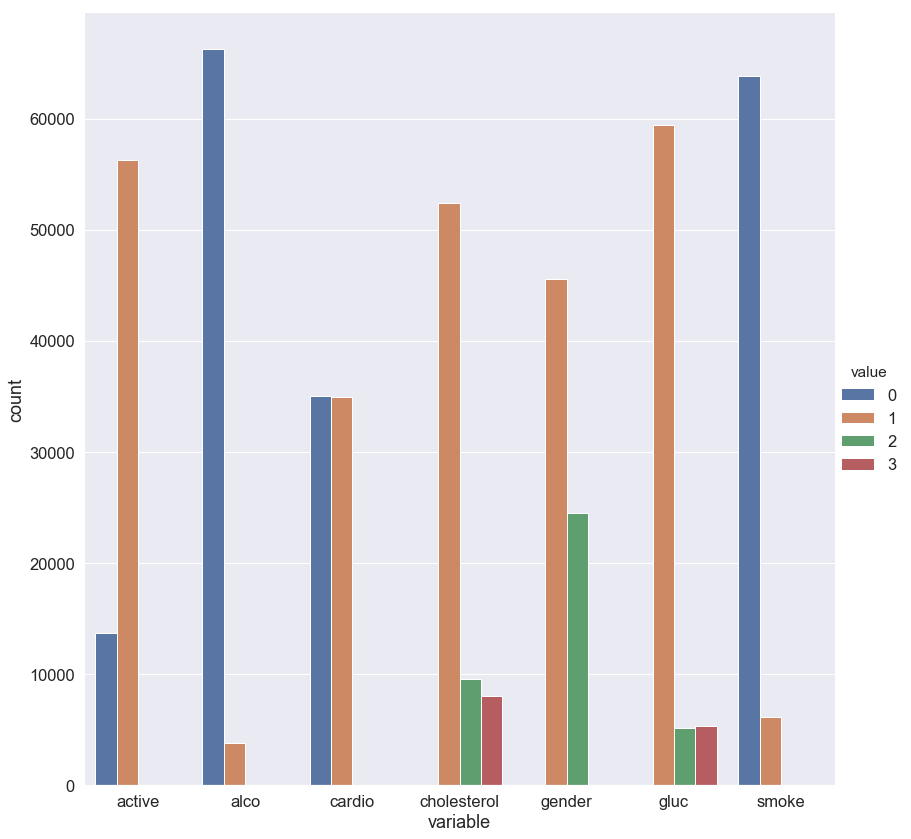

In [4]:
df_uniques = pd.melt(frame=df, value_vars=['gender','cholesterol', 
                                           'gluc', 'smoke', 'alco', 
                                           'active', 'cardio'])
df_uniques = pd.DataFrame(df_uniques.groupby(['variable', 
                                              'value'])['value'].count()) \
    .sort_index(level=[0, 1]) \
    .rename(columns={'value': 'count'}) \
    .reset_index()

sns.factorplot(x='variable', y='count', hue='value', 
               data=df_uniques, kind='bar', size=12);

We can see that the target classes are balanced. That's great!

Let's split the dataset by target values. Can you already spot the most significant feature by just looking at the plot?

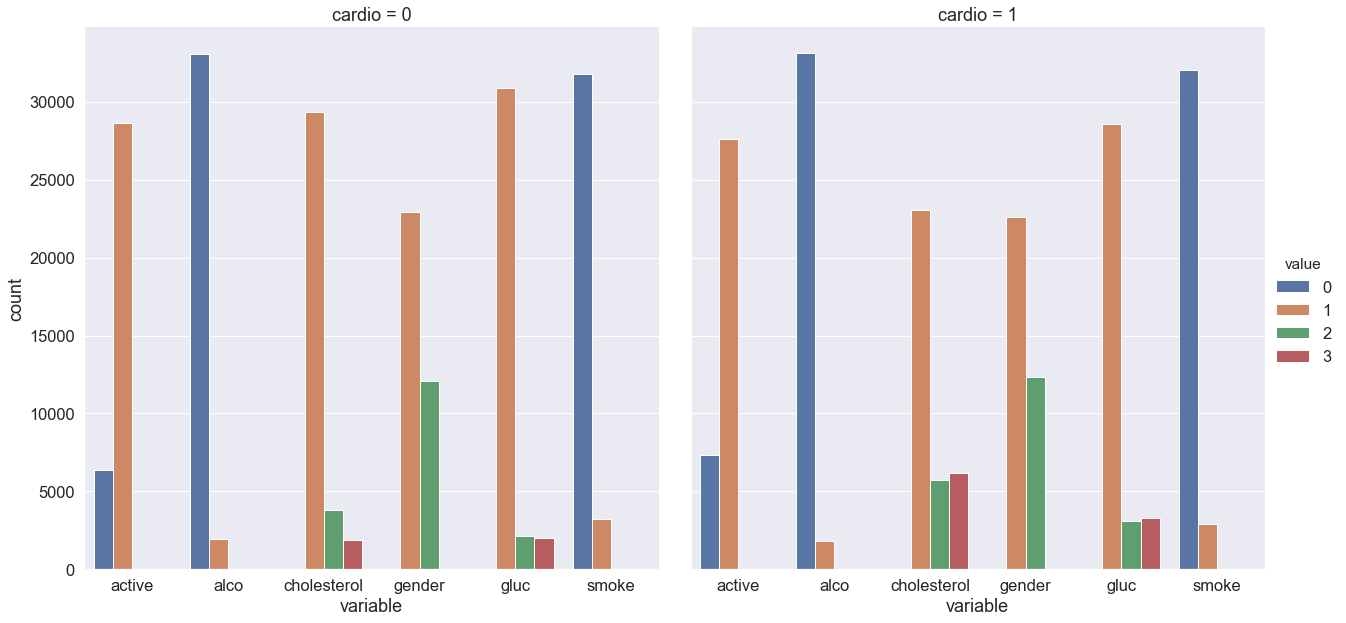

In [5]:
df_uniques = pd.melt(frame=df, value_vars=['gender','cholesterol', 
                                           'gluc', 'smoke', 'alco', 
                                           'active'], 
                     id_vars=['cardio'])

df_uniques = pd.DataFrame(df_uniques.groupby(['variable', 'value', 
                                              'cardio'])['value'].count()) \
    .sort_index(level=[0, 1]) \
    .rename(columns={'value': 'count'}) \
    .reset_index()

sns.factorplot(x='variable', y='count', hue='value', 
               col='cardio', data=df_uniques, kind='bar', size=9);

You can see that the distribution of cholesterol and glucose levels great differs by the value of the target variable. Is this a coincidence?
Don't think.

Now, let's calculate some statistics for the feature unique values:

In [6]:
for c in df.columns:
    n = df[c].nunique()
    print(c)
    if n <= 3:
        print(n, sorted(df[c].value_counts().to_dict().items()))
    else:
        print(n)
    print(10 * '-')

id
70000
----------
age
8076
----------
gender
2 [(1, 45530), (2, 24470)]
----------
height
109
----------
weight
287
----------
ap_hi
153
----------
ap_lo
157
----------
cholesterol
3 [(1, 52385), (2, 9549), (3, 8066)]
----------
gluc
3 [(1, 59479), (2, 5190), (3, 5331)]
----------
smoke
2 [(0, 63831), (1, 6169)]
----------
alco
2 [(0, 66236), (1, 3764)]
----------
active
2 [(0, 13739), (1, 56261)]
----------
cardio
2 [(0, 35021), (1, 34979)]
----------


In the end, we have:
- 5 numerical features (excluding *id*);
- 7 categorical features;
- 70000 records in total.

## 1.1. Basic observations

**Question 1.1. (1 point). How many men and women are present in this dataset? Values of the `gender` feature were not given (whether "1" stands for women or for men) – figure this out by looking analyzing height, making the assumption that men are taller on average. **
1. 45530 women and 24470 men v
2. 45530 men and 24470 women
3. 45470 women and 24530 men
4. 45470 men and 24530 women

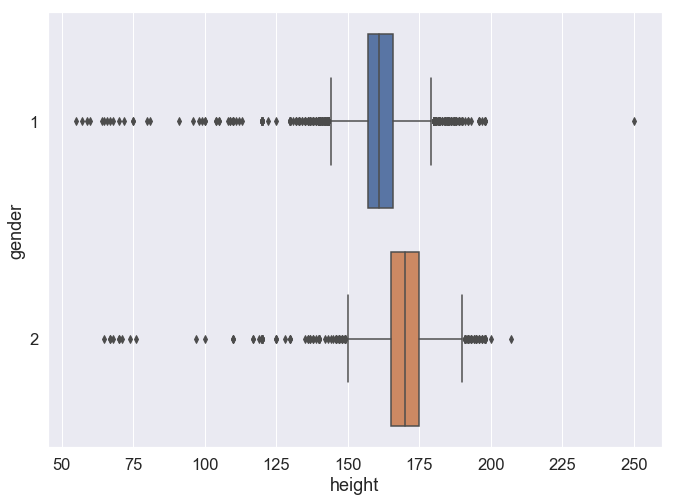

In [9]:
gender_height = df[['gender', 'height']]
sns.boxplot(y="gender", x="height", data=gender_height, orient="h");

1 - Female
2 - Male

**Question 1.2. (1 point). Which gender more often reports consuming alcohol - men or women?**
1. women
2. men v

   gender  alco
0       1  1161
1       2  2603


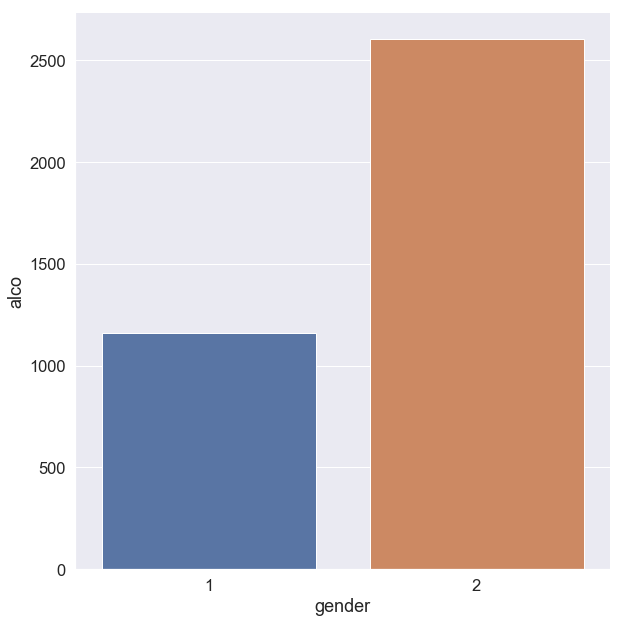

In [8]:
gender_alco = df[['gender', 'alco']]
gender_alco = pd.DataFrame(gender_alco.groupby(['gender'])['alco'].sum()) \
    .reset_index()
print(gender_alco)
sns.factorplot(x='gender', y='alco', data=gender_alco, kind='bar', size=9);

**Question 1.3. (1 point). What is the difference between the percentages of smokers among men and women (rounded)?**
1. 4
2. 16
3. 20 v
4. 24

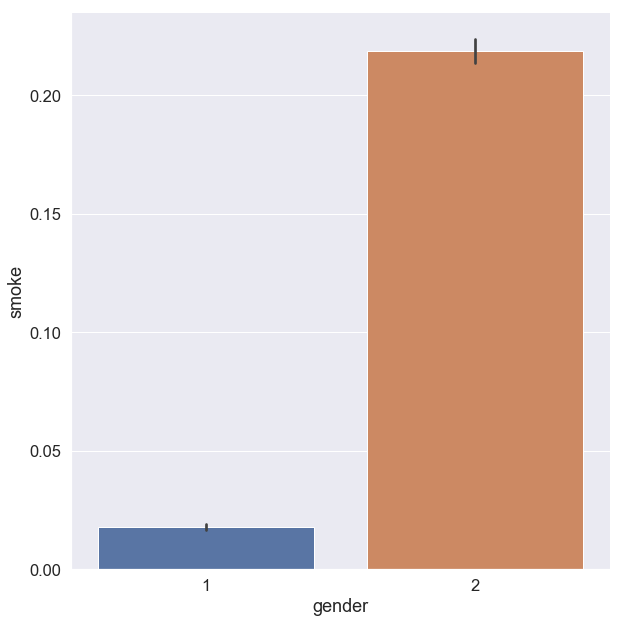

In [7]:
gender_smoke = df[['gender', 'smoke']]
sns.factorplot(x='gender', y='smoke', data=gender_smoke, kind='bar', size=9);

**Question 1.4. (1 point). What is the difference between median values of age for smokers and non-smokers (in months, rounded)? You'll need to figure out the units of feature `age` in this dataset.**

1. 5
2. 10
3. 15 v
4. 20

   smoke         age
0      0  650.180024
1      1  636.361231


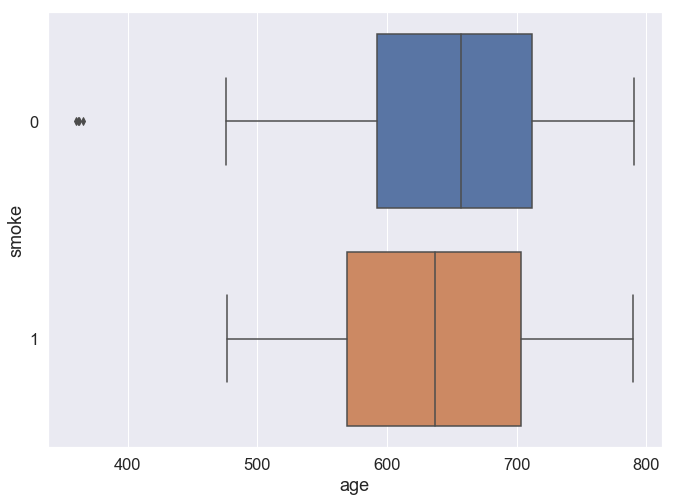

In [10]:
age_smoke = df[['age', 'smoke']]
age_smoke['age'] = age_smoke['age']/30
print(age_smoke.groupby(['smoke'])['age'].mean().reset_index())
sns.boxplot(y="smoke", x="age", data=age_smoke, orient="h");

## 1.2. Risk maps
### Task:

On the website for the European Society of Cardiology, a [SCORE scale](https://www.escardio.org/Education/Practice-Tools/CVD-prevention-toolbox/SCORE-Risk-Charts) is provided. It is used for calculating the risk of death from a cardiovascular decease in the next 10 years. Here it is:
<img src='../../img/SCORE_CVD_eng.png' width=70%>

Let's take a look at the upper-right rectangle, which shows a subset of smoking men aged from 60 to 65. (It's not obvious, but the values in the figure represent the upper bound).

We see the value 9 in the lower-left corner of the rectangle and 47 in the upper-right. This means that, for people in this gender-age group whose systolic pressure is less than 120, the risk of a CVD is estimated to be 5 times lower than for those with the pressure in the interval [160,180).

Let's calculate that same ratio using our data.

Clarifications:
- Calculate ``age_years`` feature – round age to the nearest number of years. For this task, select only the people of age 60 to 64, inclusive.
- Cholesterol level categories differ between the figure and our dataset. The conversion for the ``cholesterol`` feature is as follows: 4 mmol/l $\rightarrow$ 1, 5-7 mmol/l $\rightarrow$ 2, 8 mmol/l $\rightarrow$ 3.

In [11]:
df['age_years'] = round(df['age'] / 365).astype('int64')

cholesterol_   4  5-7   8
ap_hi_                   
120           26   41  60
140           39   60  76
160           85   84  85
180           88   89  90
3.4615384615384617


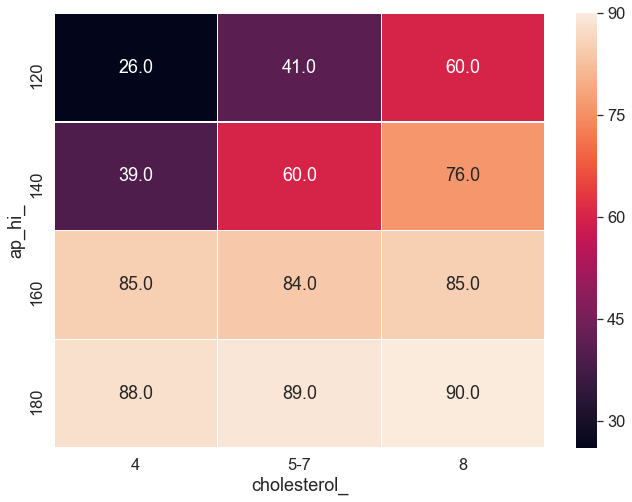

In [12]:
# You code here
df_risk = df.copy()

def replase_ap_hi(a):
    s = None
    if (a < 120):  
        s = 120
    elif (a < 140):
        s = 140
    elif (a < 160):
        s = 160
    else:
        s = 180
    return s

df_risk = df_risk[df_risk['gender'] == 2]
df_risk = df_risk[df_risk['smoke'] == 1]
df_risk = df_risk[(df_risk['age_years'] >= 60) & (df_risk['age_years'] < 65)]
df_risk['ap_hi_'] = df_risk['ap_hi'].map(replase_ap_hi)
df_risk['cholesterol_'] = df_risk['cholesterol'].map({1:'4', 2:'5-7', 3:'8'})

cvd = df_risk.pivot_table(index='ap_hi_',
                          columns='cholesterol_',
                          values='cardio', 
                          aggfunc=sum).fillna(0)

all_men = pd.crosstab(df_risk['ap_hi_'],
                      df_risk['cholesterol_'])

risk_cvd = round(cvd / all_men * 100).astype('int64')
print(risk_cvd)

sns.heatmap(risk_cvd, annot=True, fmt=".1f", linewidths=.5);

print(90/26)

**Question 1.5. (2 points). Calculate the fraction of the people with CVD for the two segments described above. What is the ratio of these two fractions?**

1. 1
2. 2
3. 3 v
4. 4 

## 1.3. Analyzing BMI
### Task:

Create a new feature – BMI ([Body Mass Index](https://en.wikipedia.org/wiki/Body_mass_index)). To do this, divide weight in kilogramms by the square of the height in meters. Normal BMI values are said to be from 18.5 to 25. 

In [14]:
# You code here
df['BMI'] = round(df['weight'] / (df['height'] / 100) ** 2, 1)

In [15]:
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)


trace0 = go.Box(
    y=np.array(df['BMI'])
)

data = [trace0]
iplot(data)


<img src='../../img/img_1.png' width=100%>

In [16]:

trace1 = go.Box(
    name='Female',
    y=np.array(df[df['gender'] == 1]['BMI'])
)
trace2 = go.Box(
    name='Male',
    y=np.array(df[df['gender'] == 2]['BMI'])
)

data1 = [trace1,trace2]
iplot(data1)


<img src='../../img/2.png' width=100%>

In [17]:
trace1 = go.Box(
    name='CVD',
    y=np.array(df[df['cardio'] == 1]['BMI'])
)
trace2 = go.Box(
    name='Helth',
    y=np.array(df[df['cardio'] == 0]['BMI'])
)

data1 = [trace1,trace2]
iplot(data1)

<img src='../../img/3.png' width=100%>

In [18]:
trace1 = go.Box(
    name='healthy, non-drinking women',
    y=np.array(df[(df['cardio'] == 0) & 
                  (df['alco'] == 0) &
                  (df['gender'] == 1)
                 ]['BMI'])
)
trace2 = go.Box(
    name='healthy, non-drinking men',
    y=np.array(df[(df['cardio'] == 0) & 
                  (df['alco'] == 0) &
                  (df['gender'] == 2)
                 ]['BMI'])
)

data1 = [trace1,trace2]
iplot(data1)

<img src='../../img/4.png' width=100%>

**Question 1.6. (2 points). Choose the correct statements:**

1. Median BMI in the sample is within the range of normal BMI values. 
2. The BMI for women is on average higher than for men. 
3. Healthy people have, on average, a higher BMI than the people with CVD. 
4. For healthy, non-drinking men, BMI is closer to the norm than for healthy, non-drinking women 

## 1.4. Cleaning data

### Task:
We can see that the data is not perfect. It contains "dirt" and inaccuracies. We'll see this better as we visualize the data.

Filter out the following patient segments (we consider these as erroneous data)

- diastolic pressure is higher than systolic 
- height is strictly less than 2.5 percentile (Use `pd.Series.quantile` to compute this value. If you are not familiar with the function, please read the docs.)
- height is strictly more than 97.5 percentile
- weight is strictly less than 2.5 percentile
- weight is strictly more than 97.5 percentile

This is not everything that we can do to clean this data, but this is sufficient for now.

In [19]:
# You code here
df_filtered = df[
    (df['ap_hi'] < df['ap_lo']) |
    (df['height'] < df['height'].quantile(0.025)) |
    (df['height'] > df['height'].quantile(0.975)) |
    (df['weight'] < df['weight'].quantile(0.025)) |
    (df['weight'] > df['weight'].quantile(0.975)) 
]

round(df_filtered.shape[0] / df.shape[0] * 100)

10

**Question 1.7. (2 points). What percent of the original data (rounded) did we throw away?**

1. 8
2. 9
3. 10
4. 11

# Part 2. Visual data analysis

## 2.1. Correlation matrix visualization

To understand the features better, you can create a matrix of the correlation coefficients between the features. Use the initial dataset (non-filtered).

### Task:

Plot a correlation matrix using [`heatmap()`](http://seaborn.pydata.org/generated/seaborn.heatmap.html). You can create the matrix using the standard `pandas` tools with the default parameters.

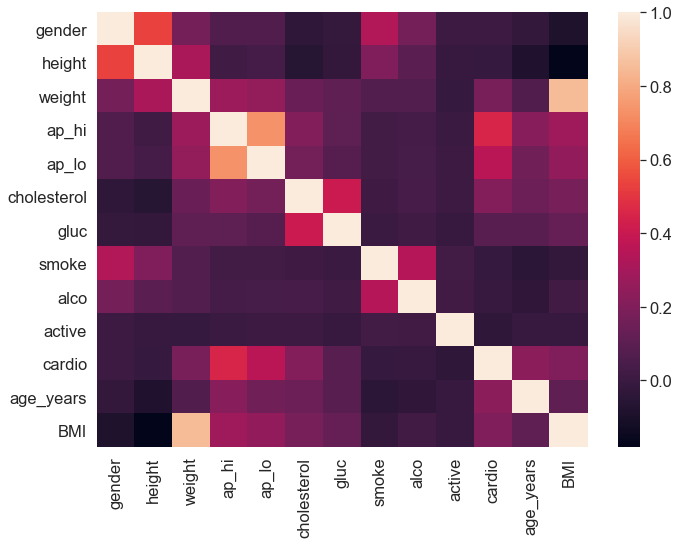

In [21]:
# You code here
corr_matrix = df.drop(['id', 'age'], axis=1).corr(method='spearman')
sns.heatmap(corr_matrix);

** Question 2.1. (1 point).** Which pair of features has the strongest Pearson's correlation with the *gender* feature?

1. Cardio, Cholesterol
2. Height, Smoke v 
3. Smoke, Alco
4. Height, Weight

## 2.2. Height distribution of men and women

From our exploration of the unique values earlier, we know that the gender is encoded by the values *1* and *2*. Although you do not know the mapping of these values to gender, you can figure that out graphically by looking at the mean values of height and weight for each value of the *gender* feature.

### Task:

Create a violin plot for the height and gender using [`violinplot()`](https://seaborn.pydata.org/generated/seaborn.violinplot.html). Use the parameters:
- `hue` to split by gender;
- `scale` to evaluate the number of records for each gender.

In order for the plot to render correctly, you need to convert your `DataFrame` to *long* format using the `melt()` function from `pandas`. Here is [an example](https://stackoverflow.com/a/41575149/3338479) of this for your reference.

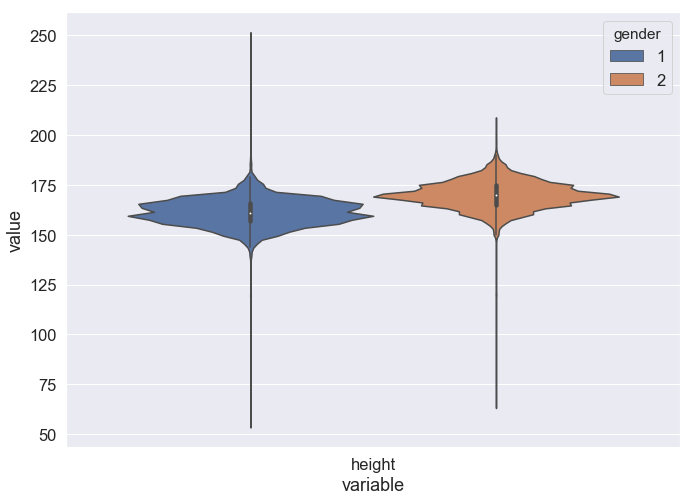

In [22]:
# You code here
df1 = pd.melt(df, value_vars='height', id_vars='gender')
sns.violinplot(x='variable', y='value', hue='gender', data=df1,scale='width');

In [23]:
corr_matrix

gender    height    weight     ap_hi     ap_lo  cholesterol  \
gender       1.000000  0.533805  0.172480  0.063174  0.066374    -0.035730   
height       0.533805  1.000000  0.313569  0.019381  0.030534    -0.058940   
weight       0.172480  0.313569  1.000000  0.277749  0.254420     0.137908   
ap_hi        0.063174  0.019381  0.277749  1.000000  0.735436     0.208722   
ap_lo        0.066374  0.030534  0.254420  0.735436  1.000000     0.167401   
cholesterol -0.035730 -0.058940  0.137908  0.208722  0.167401     1.000000   
gluc        -0.018866 -0.024369  0.109901  0.105334  0.082474     0.407803   
smoke        0.338135  0.197632  0.071676  0.028929  0.026172     0.015220   
alco         0.170966  0.096670  0.068088  0.033243  0.038862     0.041285   
active       0.005866 -0.007367 -0.014894 -0.001268  0.003401     0.007573   
cardio       0.008109 -0.012383  0.182701  0.451885  0.362572     0.215117   
age_years   -0.020697 -0.083634  0.062979  0.220780  0.157957     0.141935   
BMI         -0.087366 -0.181936  0.848464  0.281046  0.250568     0.173980   

                 gluc     smoke      alco    active    cardio  age_years  \
gender      -0.018866  0.338135  0.170966  0.005866  0.008109  -0.020697   
height      -0.024369  0.197632  0.096670 -0.007367 -0.012383  -0.083634   
weight       0.109901  0.071676  0.068088 -0.014894  0.182701   0.062979   
ap_hi        0.105334  0.028929  0.033243 -0.001268  0.451885   0.220780   
ap_lo        0.082474  0.026172  0.038862  0.003401  0.362572   0.157957   
cholesterol  0.407803  0.015220  0.041285  0.007573  0.215117   0.141935   
gluc         1.000000  0.000468  0.018584 -0.008610  0.091488   0.091777   
smoke        0.000468  1.000000  0.340094  0.025858 -0.015486  -0.047535   
alco         0.018584  0.340094  1.000000  0.025476 -0.007330  -0.030005   
active      -0.008610  0.025858  0.025476  1.000000 -0.035653  -0.010105   
cardio       0.091488 -0.015486 -0.007330 -0.035653  1.000000   0.235254   
age_years    0.091777 -0.047535 -0.030005 -0.010105  0.235254   1.000000   
BMI          0.127858 -0.024192  0.022681 -0.010000  0.199050   0.109903   

                  BMI  
gender      -0.087366  
height      -0.181936  
weight       0.848464  
ap_hi        0.281046  
ap_lo        0.250568  
cholesterol  0.173980  
gluc         0.127858  
smoke       -0.024192  
alco         0.022681  
active      -0.010000  
cardio       0.199050  
age_years    0.109903  
BMI          1.000000

**Question 2.2. (1 point).** Which pair of features has the strongest Spearman correlation?

1. Height, Weight
2. Age, Weight
3. Cholesterol, Gluc
4. Cardio, Cholesterol
5. Ap_hi, Ap_lo v
6. Smoke, Alco

**Question 2.3. (1 point).** Why do these features have strong rank correlation?

1. Inaccuracies in the data (data acquisition errors).
2. Relation is wrong, these features should not be related.
3. Nature of the data. v

## 2.4. Age

Previously, we calculated the age of the respondents in years at the moment of examination.

### Task:

Create a *count plot* using [`countplot()`](http://seaborn.pydata.org/generated/seaborn.countplot.html) with the age on the *X* axis and the number of people on the *Y* axis. Your resulting plot should have two columns for each age, corresponding to the number of people for each *cardio* class of that age.

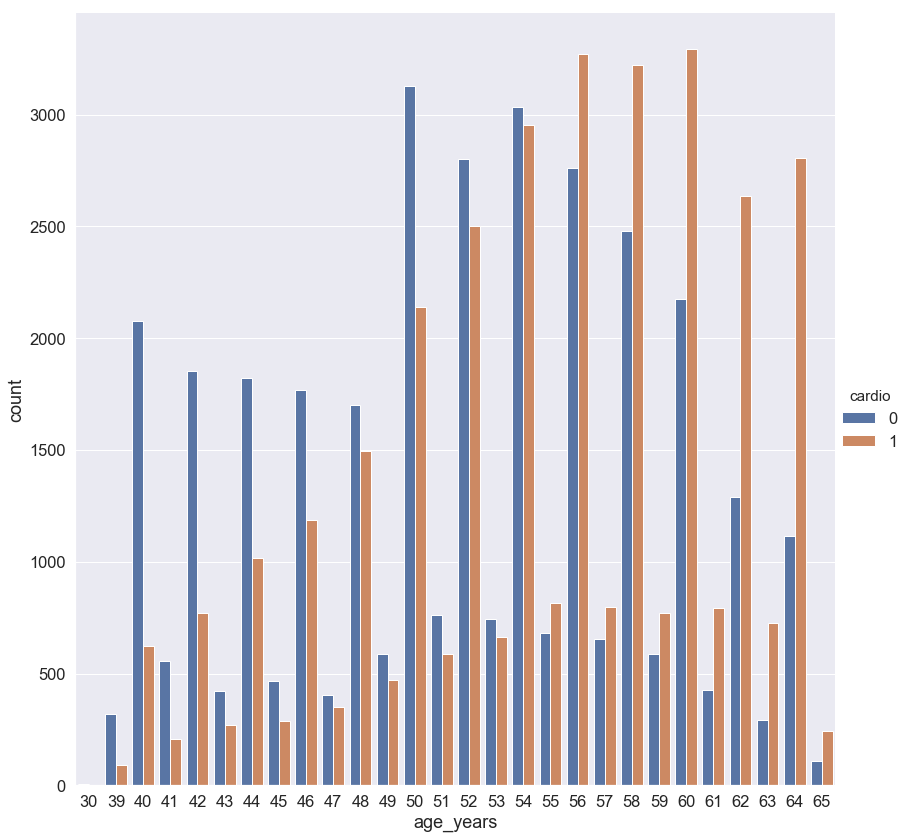

In [24]:
# You code here
df2 = df.groupby(['age_years','cardio'])['id'].count() \
    .reset_index() \
    .rename(columns={'id': 'count'})
df2

sns.factorplot(x='age_years', y='count', hue='cardio', 
               data=df2, kind='bar', size=12);

**Question 2.4. (1 point).** What is the smallest age at which the number of people with CVD outnumber the number of people without CVD?

1. 44
2. 55 v
3. 64
4. 70